# Exploration of tessellation

In search of an optimal spatial unit, this notebook explores several options of tessellation.

In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

In [2]:
db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)
engine.begin()

In [10]:
x, y = 352125.32, 492802.86  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

In [11]:
sql = f'SELECT * FROM openroads_200803_topological WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

roads = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

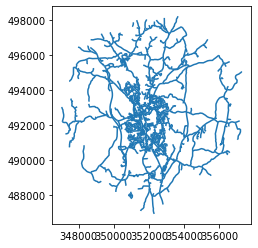

In [12]:
roads.plot()

<AxesSubplot:>

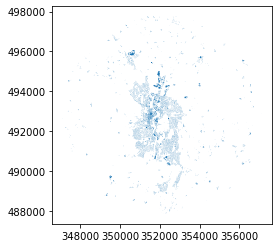

In [13]:
sql = f'SELECT * FROM openmap_buildings_200814 WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

buildings = gpd.read_postgis(sql, engine, geom_col='geometry')
buildings.plot()

In [14]:
buildings.shape

(7834, 3)

In [15]:
from shapely.geometry import Point

In [16]:
limit = Point(x, y).buffer(buffer)

In [17]:
import momepy as mm

In [19]:
buildings

,gml_id,featureCode,geometry
0,idD589F9B4-E82E-47EC-956C-D28DD3D2F706,15014,"POLYGON ((350715.880 497538.310, 350725.390 49..."
1,id1A1D8810-34E8-4BCD-BD81-C1FAB20C0944,15014,"POLYGON ((351065.450 497619.740, 351051.940 49..."
2,idC9145C5D-BF42-4CCA-8CAD-601FAD44E3C4,15014,"POLYGON ((351062.650 497630.330, 351055.710 49..."
3,idA0A87301-8873-41D3-B9EE-A5163061DDC1,15014,"POLYGON ((351085.090 497646.280, 351086.240 49..."
4,id540C742C-8BA8-4F16-8760-3EDB6FFB9F6B,15014,"POLYGON ((351096.110 497573.180, 351096.080 49..."
...,...,...,...
7829,id0620DFB7-966B-45F2-B2F6-86F9CBBAD225,15014,"POLYGON ((350879.770 490856.520, 350891.250 49..."
7830,idA38FAB2E-CAAC-4F21-85B3-D1F3D7BB4FAF,15014,"POLYGON ((350880.310 490761.290, 350876.970 49..."
7831,idC9A8E7D1-179D-4447-B113-23385DF6B2D5,15014,"POLYGON ((350881.340 490881.890, 350887.600 49..."
7832,idA55AB039-E66B-4097-AD1C-CFE92EF2E87B,15014,"POLYGON ((347493.590 491128.970, 347493.870 49..."


In [28]:
roads['uID'] = range(len(roads))

In [29]:
tes_rd = mm.Tessellation(roads, 'uID', limit, segment=10)

Inward offset...
Discretization...
100%|██████████| 2271/2271 [00:00<00:00, 6093.07it/s]
Generating Voronoi diagram...
Vertices to Polygons: 100%|██████████| 36736/36736 [00:01<00:00, 26861.00it/s]
Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...
Cutting...


In [30]:
roads_tessellation = tes_rd.tessellation

<AxesSubplot:>

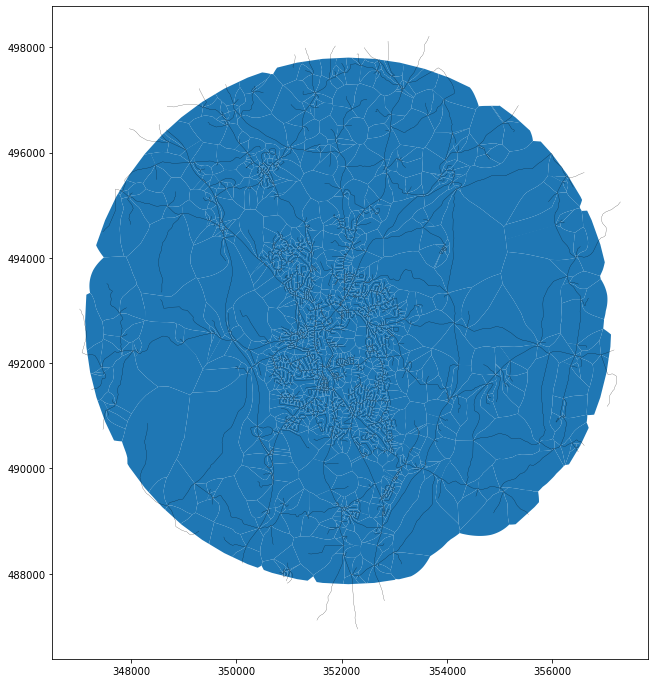

In [38]:
ax = roads_tessellation.plot(figsize=(12, 12))
roads.plot(ax=ax, color='k', linewidth=.2)

In [33]:
buildings['uID'] = range(len(buildings))

In [34]:
tes_blg = mm.Tessellation(buildings, 'uID', limit, segment=2, shrink=0)

Inward offset...
Discretization...
100%|██████████| 7834/7834 [00:02<00:00, 3899.12it/s]
Generating Voronoi diagram...
Generating GeoDataFrame...
Vertices to Polygons: 100%|██████████| 267225/267225 [00:08<00:00, 32991.76it/s]
Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...
Cutting...


In [35]:
blg_tessellation = tes_blg.tessellation

<AxesSubplot:>

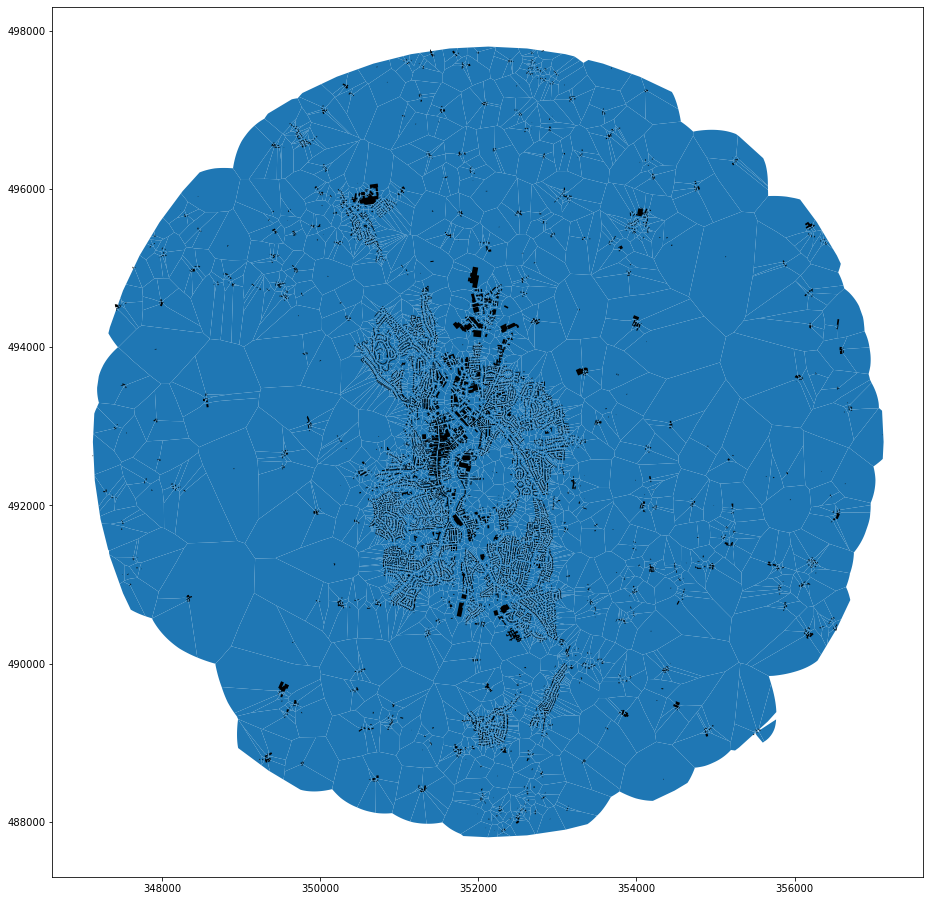

In [37]:
ax = blg_tessellation.plot(figsize=(16, 16))
buildings.plot(ax=ax, color='k')


In [45]:
union = buildings.buffer(100).unary_union

In [55]:
ind = roads.sindex.query(union, predicate='contains')

<AxesSubplot:>

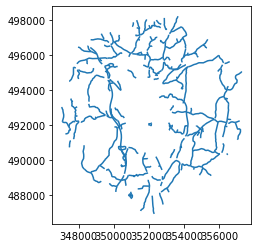

In [65]:
roads[~roads.index.isin(ind)].plot()

In [66]:
country_roads = roads[~roads.index.isin(ind)].copy()

In [67]:
country_roads.uID = country_roads.uID + 10000

In [69]:
mixed = country_roads[['uID', 'geometry']].append(buildings[['uID', 'geometry']])

In [70]:
tes_mix = mm.Tessellation(mixed, 'uID', limit, segment=2, shrink=0)

Inward offset...
Discretization...
100%|██████████| 8192/8192 [00:02<00:00, 3284.89it/s]
Generating Voronoi diagram...
Generating GeoDataFrame...
Vertices to Polygons: 100%|██████████| 340897/340897 [00:12<00:00, 27511.88it/s]
Dissolving Voronoi polygons...
100%|██████████| 7/7 [00:00<00:00, 568.84it/s]Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...
Cutting...



<AxesSubplot:>

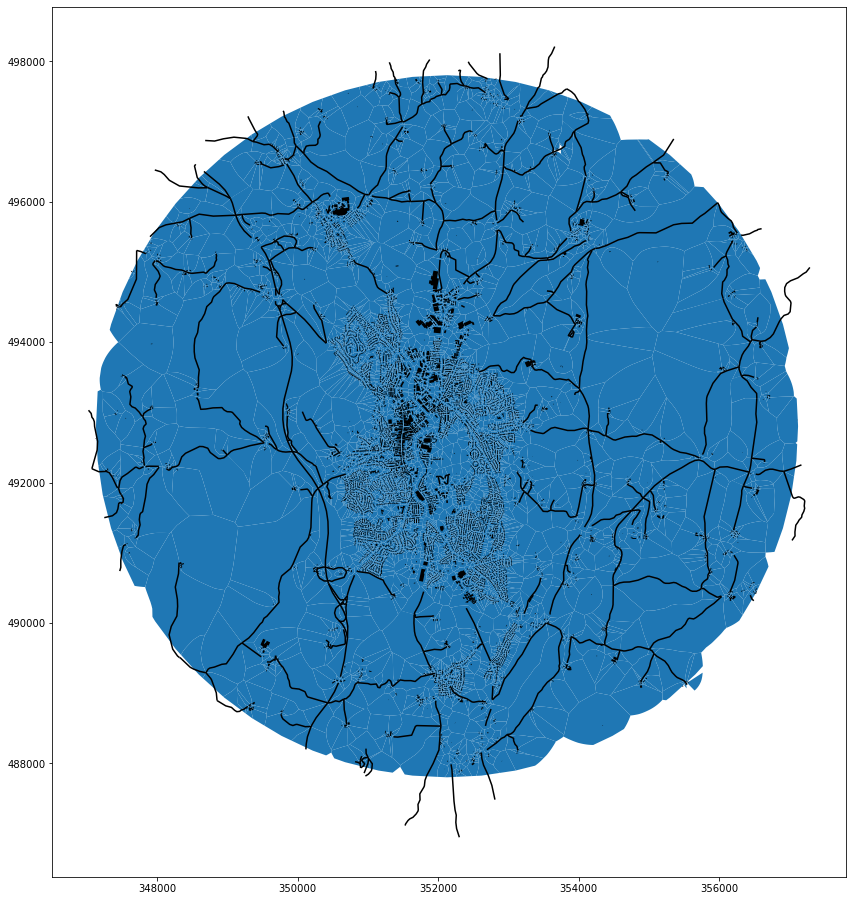

In [72]:
mixed_tessellation = tes_mix.tessellation
ax = mixed_tessellation.plot(figsize=(16, 16))
mixed.plot(ax=ax, color='k')

In [75]:
total = buildings.total_bounds

In [76]:
import numpy as np

In [78]:
pts = []

for x in np.linspace(total[0], total[2], 100):
    for y in np.linspace(total[1], total[3], 100):
        pts.append(Point(x, y))

In [79]:
pts = gpd.GeoSeries(pts)

In [84]:
grid = pts.drop(pts.sindex.query(union, predicate='intersects'))

<AxesSubplot:>

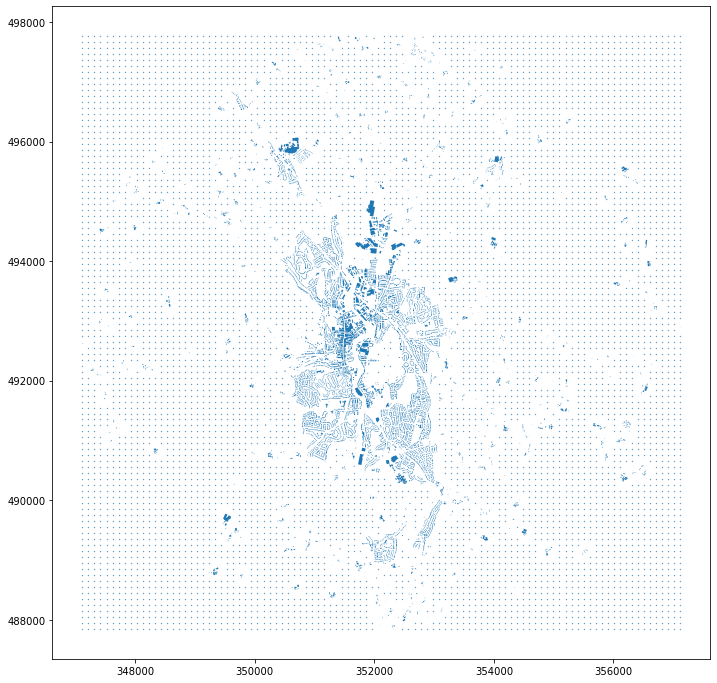

In [88]:
ax = grid.plot(markersize=.1, figsize=(12, 12))
buildings.plot(ax=ax)

In [94]:
grid = gpd.GeoDataFrame(geometry=grid, crs=buildings.crs)

In [95]:
grid['uID'] = range(len(grid))
grid['uID'] = grid['uID'] + 100000

In [96]:
# fix for momepy
grid.geometry = grid.buffer(.1)

In [103]:
buildings_grid = buildings[['uID', 'geometry']].append(grid).reset_index(drop=True)

In [104]:
buildings_grid

,uID,geometry
0,0,"POLYGON ((350715.880 497538.310, 350725.390 49..."
1,1,"POLYGON ((351065.450 497619.740, 351051.940 49..."
2,2,"POLYGON ((351062.650 497630.330, 351055.710 49..."
3,3,"POLYGON ((351085.090 497646.280, 351086.240 49..."
4,4,"POLYGON ((351096.110 497573.180, 351096.080 49..."
...,...,...
15185,107351,"POLYGON ((357117.710 497363.963, 357117.710 49..."
15186,107352,"POLYGON ((357117.710 497464.178, 357117.710 49..."
15187,107353,"POLYGON ((357117.710 497564.392, 357117.710 49..."
15188,107354,"POLYGON ((357117.710 497664.606, 357117.710 49..."


In [107]:
tes_grid = mm.Tessellation(gpd.clip(buildings_grid, limit), 'uID', limit, segment=2, shrink=0)

Inward offset...
Discretization...
100%|██████████| 12953/12953 [00:03<00:00, 3282.79it/s]
Generating Voronoi diagram...
Generating GeoDataFrame...
Vertices to Polygons: 100%|██████████| 594931/594931 [00:16<00:00, 35040.58it/s]
Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...
Identifying edge cells...
Cutting...


<AxesSubplot:>

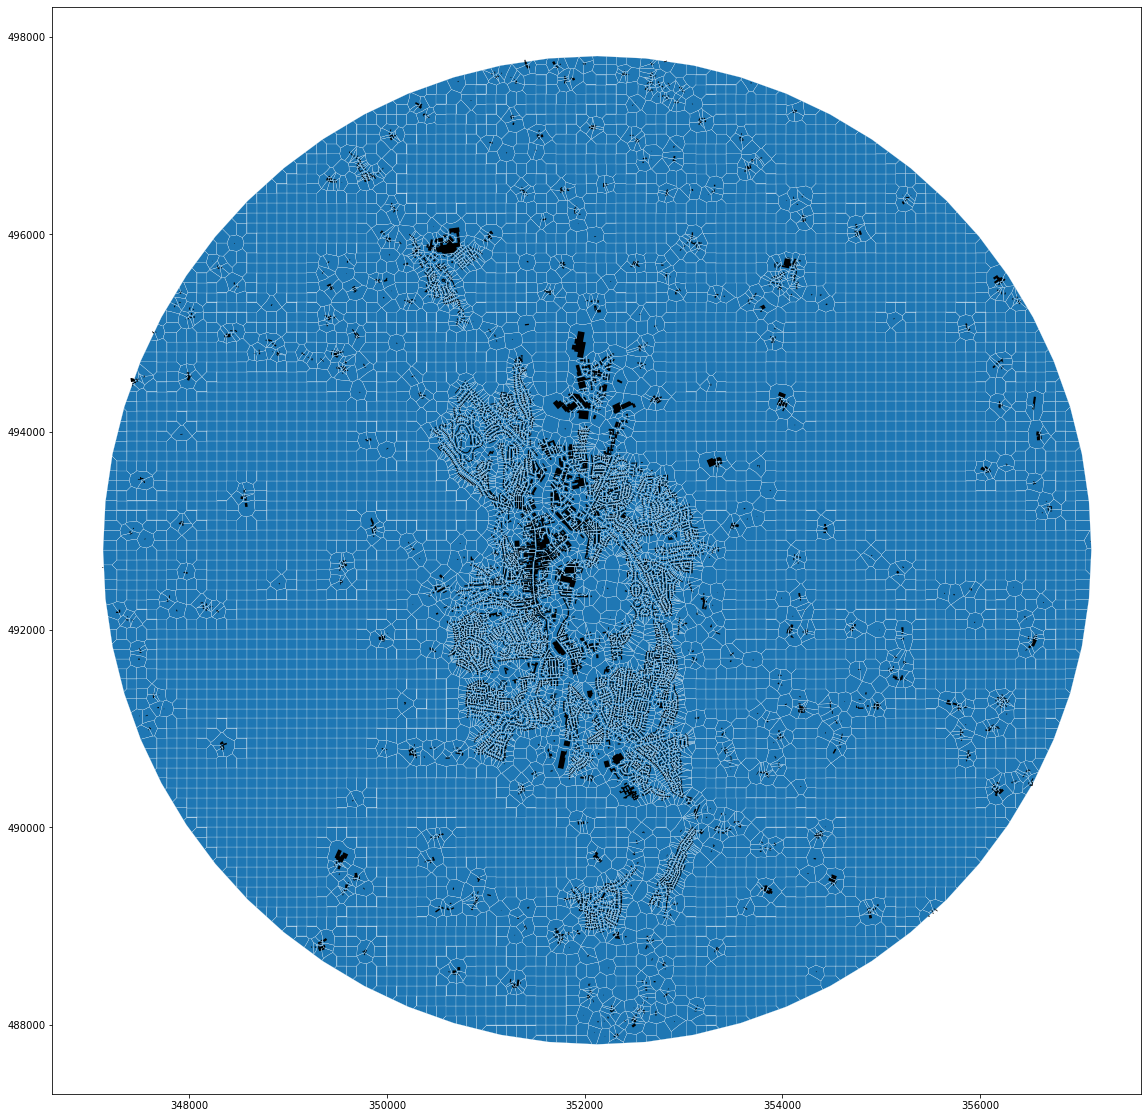

In [113]:
grid_tessellation = tes_grid.tessellation
ax = grid_tessellation.plot(figsize=(20, 20), edgecolor='w', linewidth=.2)
buildings_grid.plot(ax=ax, color='k')

In [115]:
buildings_grid.to_file('units.gpkg', layer='buildings_grid', driver='GPKG')
grid_tessellation.to_file('units.gpkg', layer='grid_tessellation', driver='GPKG')
buildings.to_file('units.gpkg', layer='buildings', driver='GPKG')
roads.to_file('units.gpkg', layer='roads', driver='GPKG')
mixed.to_file('units.gpkg', layer='mixed', driver='GPKG')
blg_tessellation.to_file('units.gpkg', layer='blg_tessellation', driver='GPKG')
roads_tessellation.to_file('units.gpkg', layer='roads_tessellation', driver='GPKG')
mixed_tessellation.to_file('units.gpkg', layer='mixed_tessellation', driver='GPKG')